# Final Project - Introduction to Machine Learning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import auc, roc_auc_score, mean_squared_error, roc_curve, RocCurveDisplay
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import AdaBoostClassifier


import time
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
data = pd.read_csv('train.csv')
df = data.copy()
df = df.iloc[: , 1:] # removing the column 'id' - not a feature
df_copy = df.copy()

##### Utility functions:

In [3]:
def change_coloumn(df, col, seperator, index): #function that deals with removing prefix/suffix
    updated_col = df[col].str.split(pat =seperator).str.get(index)
    return updated_col

def remove_column(df, col):
    return df.drop(columns=col)

In [4]:
def remove_row(x,y,index_rows):
    x = x.drop(index_rows)
    y = y.drop(index_rows)
    x.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    return(x,y)

In [5]:
def cat_filling_null(col, df, cat_most_freq, test= None):
    if test == None:
        most_freq_value = df[col].value_counts().idxmax()
        df[col].fillna(most_freq_value, inplace=True)
        cat_most_freq[col] = most_freq_value
    else:
        df[col].fillna(cat_most_freq[col], inplace=True)
    return df

In [6]:

def num_filling_null_median(col, df, num_median, test=None):
    if test == None:
        col_median = df[col].median()
        df[col].fillna(col_median, inplace=True)
        num_median[col] = col_median
    else:
        df[col].fillna(num_median[col], inplace=True)
    return df

def num_filling_null_mean(col, df, num_mean, test = None):
    if test == None:
        col_mean = df[col].mean()
        df[col].fillna(col_mean, inplace=True)
        num_mean[col] = col_mean
    else:
        df[col].fillna(num_mean[col], inplace=True)
    return df

In [7]:
def change_boolean(data, col):
    data[col] = data[col].astype(int)
    return data

In [8]:
def change_to_dummies(data, cols):
    new_data = pd.get_dummies(data, columns = cols)
    return new_data

# Part 1 - Exploration

### Overview
First we looked on parts of the rows

In [9]:
df

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,...,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
0,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,0.000000,...,1.0,safari_15,1.0,Returning_Visitor,False,c_1,118.880094,log202,NaN,0
1,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,0.000000,0.200000,0.200000,0.000000,...,4.0,safari_14,9.0,Returning_Visitor,False,c_3,113.358423,log404,NaN,0
2,0.0,0.0,0.0,NaN,NaN,627.5 minutes,627.500000,0.020000,0.050000,0.000000,...,3.0,browser_3_v17,1.0,Returning_Visitor,True,c_4,121.507695,log202,NaN,0
3,0.0,0.0,0.0,0.0 minutes,19.0,154.2166667 minutes,154.216667,0.015789,0.024561,0.000000,...,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_3,93.747176,log_100,NaN,0
4,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,0.000000,...,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,False,c_3,99.545824,log202,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10474,3.0,145.0,0.0,0.0 minutes,53.0,1783.791667 minutes,1928.791667,0.007143,0.029031,12.241717,...,4.0,browser_6_v12,1.0,Returning_Visitor,True,c_1,79.548460,log400,NaN,0
10475,0.0,0.0,0.0,0.0 minutes,5.0,465.75 minutes,NaN,0.000000,0.021333,0.000000,...,3.0,chrome_98.0.1,1.0,Returning_Visitor,True,c_8,99.457255,log202,NaN,0
10476,0.0,0.0,0.0,0.0 minutes,6.0,184.25 minutes,NaN,0.083333,0.086667,0.000000,...,3.0,chrome_99.1.3,1.0,Returning_Visitor,True,c_13,94.417344,log8080,NaN,0
10477,4.0,75.0,0.0,0.0 minutes,15.0,346.0 minutes,NaN,0.000000,0.021053,0.000000,...,2.0,chrome_80,3.0,Returning_Visitor,False,c_11,108.919057,log400,NaN,0


In [10]:
num_feat = df.shape[1] - 1 # removing the columns of the label (purchase) - not a feature
print (f'The train data has {df.shape[0]} rows(samples) and {num_feat} columns(features)')

The train data has 10479 rows(samples) and 21 columns(features)


### Split the data to train and test data sets

In [11]:
#Converting data to 2 arrays of x and y
X = df.iloc[:,:-1].values
y = df.iloc[:,-1]
print(f'X.shape: {X.shape}, y.shape: {y.shape}')
#split to train and test
X_train ,X_test ,y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state= 42, shuffle=True)
print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}, \
X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}')
#converting to panda data frame
name_col = df.columns[:-1]
types_col = dict(df.dtypes[:-1])
X_train = pd.DataFrame(X_train, columns = name_col)
X_test = pd.DataFrame(X_test, columns = name_col)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
X_train = X_train.astype(types_col)
X_test = X_test.astype(types_col)
#reset indices
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
x_train_copy = X_train.copy()
y_train_copy = y_train.copy()
x_test_copy = X_test.copy()
y_test_copy = y_test.copy()

X.shape: (10479, 21), y.shape: (10479,)
X_train.shape: (8383, 21), y_train.shape: (8383,), X_test.shape: (2096, 21), y_test.shape: (2096,)


Number of observations labeled as '0': 7078 which are 0.8443278062746034 from the data 
Number of observations of labeled as '1': 1305 which are 0.15567219372539665 from the data 
In column 'purchase', Number of observations of null: 0


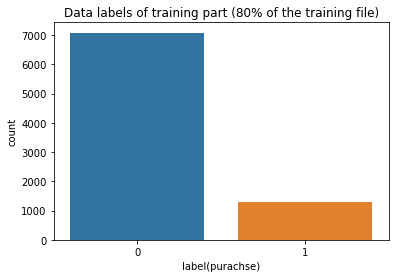

In [12]:
#count of each label
label_0 = y_train["purchase"].value_counts()[0]
label_0_pre = label_0/float(y_train.shape[0])
label_1 = y_train["purchase"].value_counts()[1]
label_1_pre = label_1/float(y_train.shape[0])
print (f"Number of observations labeled as '0': {label_0} which are {label_0_pre} from the data ")
print (f"Number of observations of labeled as '1': {label_1} which are {label_1_pre} from the data ")
print(f"In column 'purchase', Number of observations of null: {(y_train['purchase'].isnull().sum(axis=0))}")
labels = [0,1]
values = [label_0,label_1]

sns.barplot(x = labels,y = values)
plt.xlabel('label(purachse)')
plt.ylabel("count")
plt.title(r"Data labels of training part (80% of the training file)")
plt.show() 


Number of observations of labeled as '0': 1780 which are 0.8492366412213741 from the data 
Number of observations of labeled '1': 316 which are 0.15076335877862596 from the data 
In column 'purchase', Number of observations of null: 0


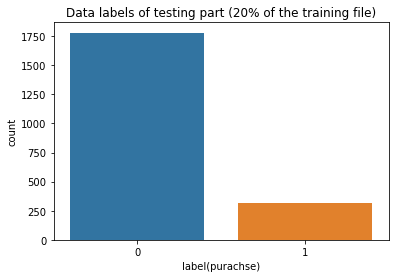

In [13]:
#count of each label
label_0 = y_test["purchase"].value_counts()[0]
label_0_pre = label_0/float(y_test.shape[0])
label_1 = y_test["purchase"].value_counts()[1]
label_1_pre = label_1/float(y_test.shape[0])
print (f"Number of observations of labeled as '0': {label_0} which are {label_0_pre} from the data ")
print (f"Number of observations of labeled '1': {label_1} which are {label_1_pre} from the data ")
print(f"In column 'purchase', Number of observations of null: {(y_test['purchase'].isnull().sum(axis=0))}")
labels = [0,1]
values = [label_0,label_1]

sns.barplot(x = labels,y = values)
plt.xlabel('label(purachse)')
plt.ylabel("count")
plt.title(r"Data labels of testing part (20% of the training file)")
plt.show() 

We can see that in column 'purchase' there are not any missing values but, the representation for each label is clearly not equal.

### Missing data

In [14]:
a = X_train.isnull().sum()
a[a>0]

num_of_admin_pages        472
admin_page_duration       324
num_of_info_pages         568
info_page_duration        251
num_of_product_pages      318
product_page_duration     489
total_duration           3810
BounceRates                16
ExitRates                  22
PageValues                 18
closeness_to_holiday      396
Month                      22
device                    270
internet_browser          462
Region                     16
user_type                  17
Weekend                    15
A                         569
B                          14
C                          16
D                        8299
dtype: int64


D : Most of the values are missing, We will consider to remove that column later.

total_duration : A significant portion missing values. We will check if this column contains the sum of other duration columns:<br>
'admin_page_duration', 'info_page_duration', 'product_page_duration'.

### Types of the features

In [15]:
X_train.dtypes

num_of_admin_pages       float64
admin_page_duration      float64
num_of_info_pages        float64
info_page_duration        object
num_of_product_pages     float64
product_page_duration     object
total_duration           float64
BounceRates              float64
ExitRates                float64
PageValues               float64
closeness_to_holiday     float64
Month                     object
device                   float64
internet_browser          object
Region                   float64
user_type                 object
Weekend                   object
A                         object
B                        float64
C                         object
D                        float64
dtype: object

In [16]:
all_cols = X_train.columns 
numeric = X_train.select_dtypes(include=[np.number]).columns
non_numeric = list(set(all_cols) - set(numeric))
print(f"Features that are not numerical: {non_numeric}")

Features that are not numerical: ['C', 'user_type', 'internet_browser', 'info_page_duration', 'product_page_duration', 'Weekend', 'Month', 'A']


We handled columns that have the "minutes" suffix and converted them to a numeric type:

In [17]:
# handling columns with 'minutes' suffix
cols_to_change = ["info_page_duration", "product_page_duration"]
for col in cols_to_change:
    X_train[col] = change_coloumn(X_train, col, " ", 0)
    X_train[col] = X_train[col].astype(float)


all_cols = X_train.columns 
numeric = list(X_train.select_dtypes(include=[np.number]).columns)
non_numeric = list(set(all_cols) - set(numeric))
print(f"Binary and categorial columns: {non_numeric}")
print(f"Numerical columns: {numeric}")

Binary and categorial columns: ['C', 'user_type', 'internet_browser', 'A', 'Weekend', 'Month']
Numerical columns: ['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages', 'info_page_duration', 'num_of_product_pages', 'product_page_duration', 'total_duration', 'BounceRates', 'ExitRates', 'PageValues', 'closeness_to_holiday', 'device', 'Region', 'B', 'D']


We examined whether the column “total_duration” (when it’s not null) is the sum of other 'duration' columns('admin_page_duration', 'info_page_duration', 'product_page_duration'):

In [18]:
cols_duration = [x for x in X_train.columns if x.endswith('_duration') and not x.startswith('total') ]
indices = ~X_train["total_duration"].isna()
true_sum =(X_train[cols_duration][indices].sum(axis=1) == X_train["total_duration"][indices])
prec = true_sum[true_sum].shape[0]/true_sum.shape[0]
a = (X_train[cols_duration][indices].sum(axis=1))-X_train["total_duration"][indices]
print(f"precentage of total_duration which is not null and the value it's the sum of other duration columns: {prec*100}%")

precentage of total_duration which is not null and the value it's the sum of other duration columns: 66.10540126831401%


In our opinion, it’s not a high percentage. Therefore, we choose not to fill null values with the sum of other duration columns.

We assumed that Region and device are categorical features so we updated their column type accordingly.

In [19]:
for x in ["device", "Region"]:
    numeric.remove(x)
    non_numeric.append(x)
    X_train[x] = X_train[x].astype(object)
print(f"Binary and categorial columns: {non_numeric}")
print(f"Numerical columns: {numeric}")

Binary and categorial columns: ['C', 'user_type', 'internet_browser', 'A', 'Weekend', 'Month', 'device', 'Region']
Numerical columns: ['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages', 'info_page_duration', 'num_of_product_pages', 'product_page_duration', 'total_duration', 'BounceRates', 'ExitRates', 'PageValues', 'closeness_to_holiday', 'B', 'D']


## Binary and categorial columns

In [20]:
X_train.describe(include=np.object)  

,Month,device,internet_browser,Region,user_type,Weekend,A,C
count,8361,8113.0,7921,8367.0,8366,8368,7814,8367
unique,10,8.0,125,9.0,3,2,91,6
top,May,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_2,log200
freq,2283,4334.0,896,3269.0,7132,6466,2520,1447


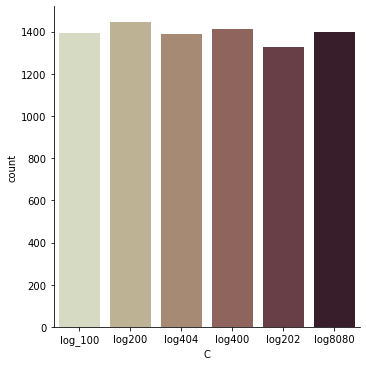

log200     1447
log400     1413
log8080    1400
log_100    1391
log404     1388
log202     1328
NaN          16
Name: C, dtype: int64


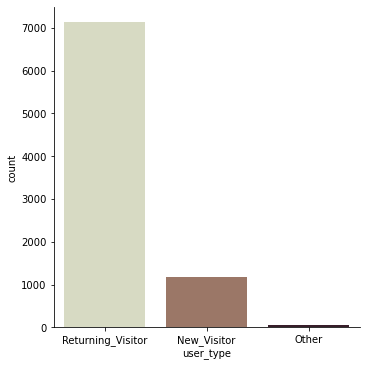

Returning_Visitor    7132
New_Visitor          1170
Other                  64
NaN                    17
Name: user_type, dtype: int64


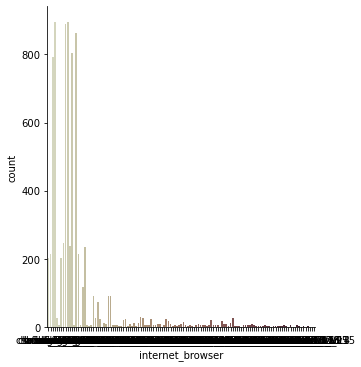

chrome_99.1.3     896
chrome_99.1.4     894
chrome_89         889
chrome_98.0.1     862
chrome_80         805
                 ... 
browser_12_v18      1
browser_11_v17      1
browser_13_v11      1
browser_7_v8        1
browser_12_v12      1
Name: internet_browser, Length: 126, dtype: int64


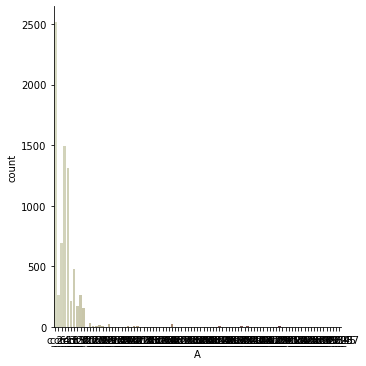

c_2        2520
c_1        1490
c_3        1314
c_4         694
NaN         569
           ... 
c_20_72       1
c_20_53       1
c_20_95       1
c_20_92       1
c_20_43       1
Name: A, Length: 92, dtype: int64


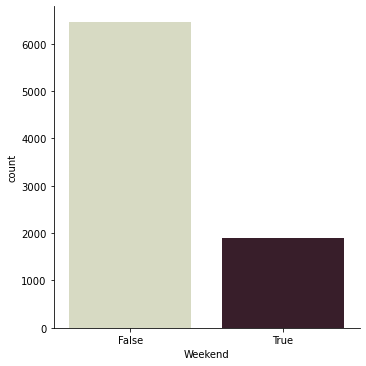

False    6466
True     1902
NaN        15
Name: Weekend, dtype: int64


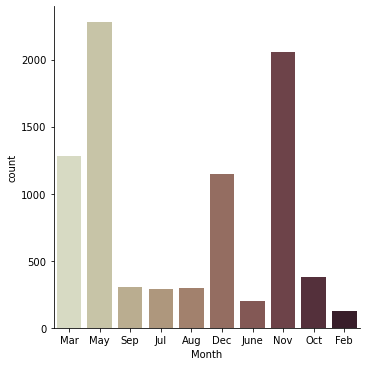

May     2283
Nov     2055
Mar     1278
Dec     1148
Oct      378
Sep      307
Aug      297
Jul      289
June     197
Feb      129
NaN       22
Name: Month, dtype: int64


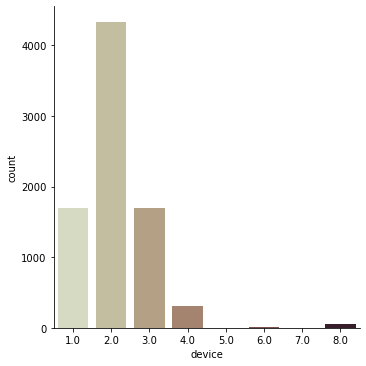

2.0    4334
3.0    1701
1.0    1698
4.0     302
NaN     270
8.0      56
6.0      17
5.0       3
7.0       2
Name: device, dtype: int64


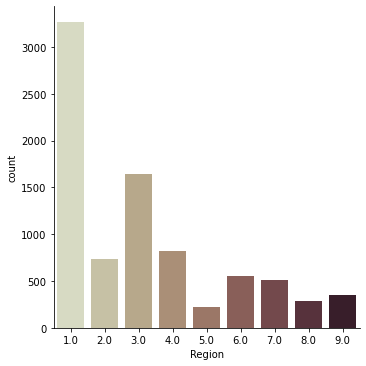

1.0    3269
3.0    1638
4.0     816
2.0     737
6.0     552
7.0     509
9.0     345
8.0     282
5.0     219
NaN      16
Name: Region, dtype: int64


In [21]:
for x in non_numeric:
    sns.catplot(x=x, kind="count", palette="ch:.50", data=X_train)
    plt.show()
    print(X_train[x].value_counts(dropna=False))

## Numerical columns

In [22]:
numeric


['num_of_admin_pages',
 'admin_page_duration',
 'num_of_info_pages',
 'info_page_duration',
 'num_of_product_pages',
 'product_page_duration',
 'total_duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'closeness_to_holiday',
 'B',
 'D']

In [23]:
X_train[numeric].describe()

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,B,D
count,7911.000000,8059.000000,7815.000000,8132.000000,8065.000000,7894.000000,4573.000000,8367.000000,8361.000000,8365.000000,7987.000000,8369.000000,84.000000
mean,2.351409,81.066483,0.511708,34.847788,32.125604,1213.107090,1307.538702,0.022110,0.043079,6.012056,0.061825,99.712158,4.006586
std,3.359179,181.143843,1.283805,144.575294,45.347025,2012.101754,2072.979345,0.048447,0.048563,19.410617,0.198236,10.057833,2.237365
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.733919,-1.235571
25%,0.000000,0.000000,0.000000,0.000000,7.000000,186.550000,221.500000,0.000000,0.014286,0.000000,0.000000,93.031643,3.241631
50%,1.000000,8.000000,0.000000,0.000000,18.000000,608.858333,681.833333,0.003093,0.025292,0.000000,0.000000,99.727150,4.442277
75%,4.000000,94.000000,0.000000,0.000000,38.000000,1480.997916,1615.757576,0.016667,0.050000,0.000000,0.000000,106.506599,5.522205
max,24.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,47850.920680,0.200000,0.200000,361.763742,1.000000,136.053396,7.618254


We can see that there are differences between std and value's range for different features. We will normalize it later.

### Histograms

array([[<AxesSubplot:title={'center':'num_of_admin_pages'}>,
        <AxesSubplot:title={'center':'admin_page_duration'}>,
        <AxesSubplot:title={'center':'num_of_info_pages'}>,
        <AxesSubplot:title={'center':'info_page_duration'}>],
       [<AxesSubplot:title={'center':'num_of_product_pages'}>,
        <AxesSubplot:title={'center':'product_page_duration'}>,
        <AxesSubplot:title={'center':'total_duration'}>,
        <AxesSubplot:title={'center':'BounceRates'}>],
       [<AxesSubplot:title={'center':'ExitRates'}>,
        <AxesSubplot:title={'center':'PageValues'}>,
        <AxesSubplot:title={'center':'closeness_to_holiday'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'D'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

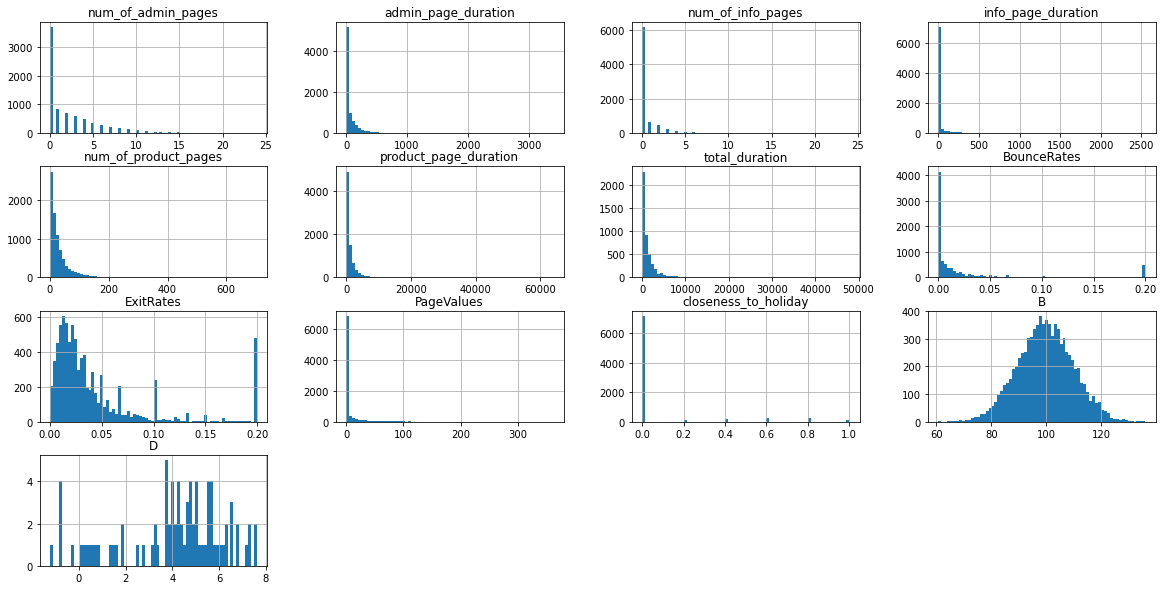

In [24]:

X_train[numeric].hist(figsize=(20,10), bins = 70)


We can see that only feature "B" distribute normally.

### Boxplots

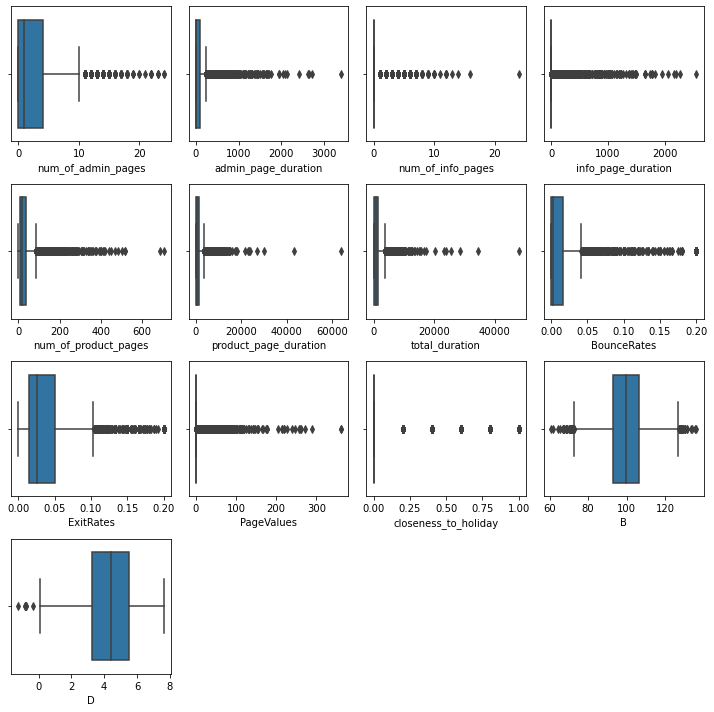

In [25]:

a = 4  
b = 4 
c = 1  # initialize plot counter

fig = plt.figure(figsize=(10,10))

for i in X_train[numeric].columns:
    plt.subplot(a, b, c)
    plt.xlabel(i)
    sns.boxplot(X_train[i])
    c = c + 1

plt.tight_layout()
plt.show()

We can see the existence of different range of values for each feature and that there exceptional values that we will relate to them later.

### Correlation matrix

correlation matrix


<AxesSubplot:>

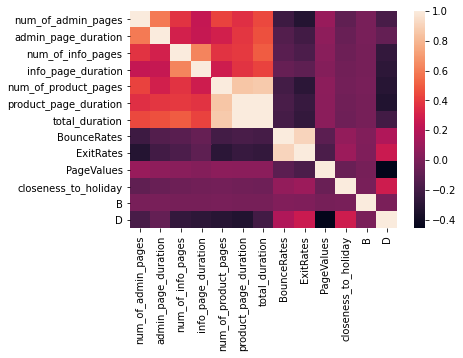

In [26]:
print("correlation matrix")
corr = X_train[numeric].corr()
sns.heatmap(corr)

In [27]:
corr_mat = X_train[numeric].corr(method='pearson').abs()
corr_mat = corr_mat[(corr_mat>0.55) & (corr_mat!=1)]
  
# Convert correlation matrix to 1-D Series and sort
sorted_mat = corr_mat.unstack().sort_values(ascending=False).dropna()
sorted_mat[::2]

total_duration         product_page_duration    0.994679
ExitRates              BounceRates              0.912051
total_duration         num_of_product_pages     0.874135
product_page_duration  num_of_product_pages     0.855297
info_page_duration     num_of_info_pages        0.628956
admin_page_duration    num_of_admin_pages       0.589940
dtype: float64

We focused on medium and high correlations (corr>0.55).<br>
Total durarion has high corrlation with both 'product page duration' and 'num of product pages'. We may consider to drop 'total duration' column becuse we found earlier that total_duration has a lot of missing values.<br>
Each 'type and duration of page' column is highly correlated with its equivalent 'type and number of pages' column. We may consider to either combine these columns or to drop one of them.<br>
ExitRates and BonuceRates are highly correlated. We may consider to either combine these columns or to drop one of them.

# Part 2 - Preprocessing

### Removing rows with missing data

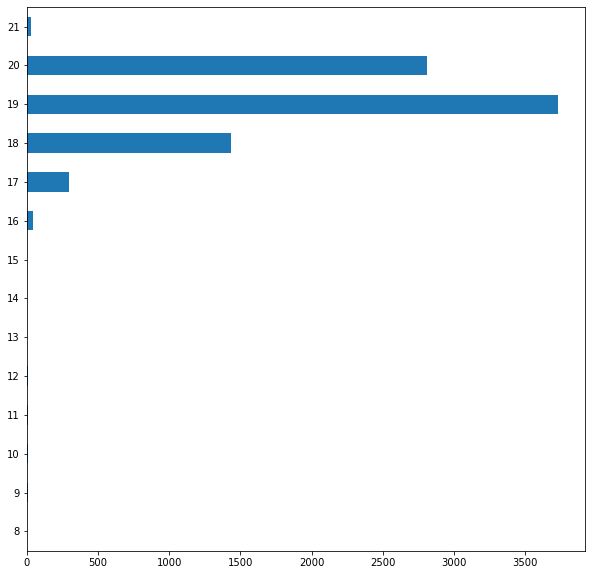

8        1
9        6
10      10
11       9
12      10
13       3
14       2
15       2
16      40
17     297
18    1431
19    3733
20    2812
21      27
dtype: int64


In [28]:
feature_count = X_train.shape[1] - X_train.isnull().sum(axis=1)
samples = feature_count.value_counts().sort_index()
samples.plot.barh(x=samples.keys() ,y=samples.values, figsize=(10,10))
plt.show()
print(samples)

In [29]:
less_17_features = feature_count.values<17
less_17_features_sum =less_17_features.sum()
features_17 = feature_count.values == 17
features_17_sum = features_17.sum()
pre_less_17 = less_17_features_sum/X_train.shape[0] *100
print(f"In the train, only {less_17_features_sum} samples of total {X_train.shape[0]} ({pre_less_17}%) have 16 features or less (out of {X_train.shape[1]}). We decided to remove this samples.")



In the train, only 83 samples of total 8383 (0.9900990099009901%) have 16 features or less (out of 21). We decided to remove this samples.


In [30]:
# remove rows which have less 17 features
to_remove = np.where(less_17_features)
X_train, y_train = remove_row(X_train, y_train, to_remove[0])


In [31]:
# to validate that we removed all necessary rows (should return 0)
feature_count = X_train.shape[1] - X_train.isnull().sum(axis=1)
less_17_features = feature_count.values<17
less_17_features_sum =less_17_features.sum()
print(less_17_features_sum)

0


### Outlier removal

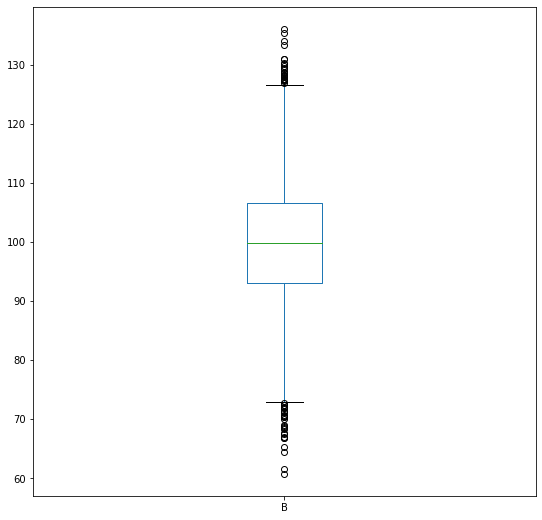

In [32]:
X_train['B'].plot(kind='box', figsize=(9, 9))
plt.show()

As we saw earlier, only column B distribute nornally, We tried to identify outliers in column B with Interquartile Range (IQR):

In [33]:

Q1 = X_train["B"].quantile(0.25)
Q3 = X_train["B"].quantile(0.75)
IQR = Q3 - Q1
B_outlier = (X_train["B"] < (Q1 - 1.5 * IQR)) |(X_train["B"] > (Q3 + 1.5 * IQR))
print(f"Nunber of samples which are oulier according to feature B: {B_outlier.sum()}")

Nunber of samples which are oulier according to feature B: 58


In [34]:
#remove outlier samples in feature B
to_remove = np.where(B_outlier)
X_train, y_train = remove_row(X_train, y_train, to_remove[0])


In [35]:
#validate we removed all the required outliers (should return 0)
B_outlier = (X_train["B"] < (Q1 - 1.5 * IQR)) |(X_train["B"] > (Q3 + 1.5 * IQR))
B_outlier.sum()

0

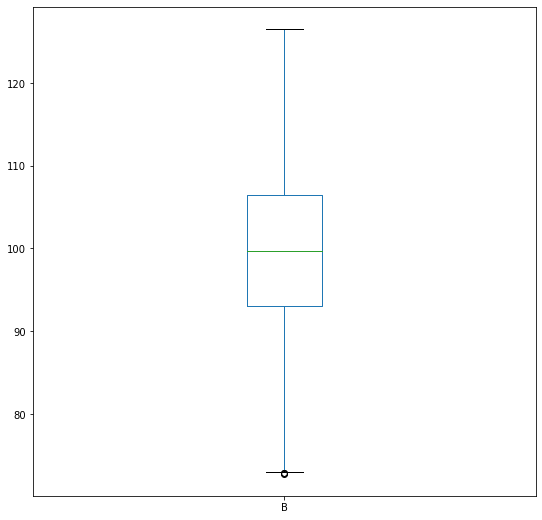

In [36]:
X_train["B"].plot(kind='box', figsize=(9, 9))
plt.show()

### Removing column D

As we saw in previous, most of the values of column D are missing. We will remove that column.

In [37]:
X_train = remove_column(X_train, "D")
X_train

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Month,device,internet_browser,Region,user_type,Weekend,A,B,C
0,2.0,18.00,NaN,0.0,30.0,474.500000,492.500000,0.000000,0.003226,0.000000,0.0,Mar,1,safari_14.1,3,Returning_Visitor,True,c_2,97.956342,log_100
1,2.0,54.00,0.0,0.0,11.0,220.966667,274.966667,0.020513,0.029487,0.000000,0.0,May,1,safari_14.1,4,Returning_Visitor,False,c_6,111.762295,log200
2,0.0,0.00,1.0,11.0,54.0,1299.196667,1310.196667,0.003636,0.022545,0.000000,0.0,Sep,1,safari_13.1,3,Returning_Visitor,True,c_2,101.429366,log_100
3,2.0,NaN,0.0,0.0,16.0,346.386667,NaN,0.000000,0.029412,0.000000,0.0,Jul,3,chrome_90.1.7,3,Returning_Visitor,False,c_4,99.304262,log404
4,0.0,0.00,0.0,0.0,9.0,166.120000,166.120000,0.000000,0.022222,0.000000,0.0,Jul,2,chrome_99.1.4,1,Returning_Visitor,False,c_1,107.093749,log400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8237,10.0,519.00,0.0,0.0,89.0,2577.960349,NaN,0.012852,0.037291,0.000000,0.0,Jul,NaN,chrome_98.0.1,7,Returning_Visitor,False,c_1,102.585479,log200
8238,2.0,9.00,0.0,0.0,18.0,558.193333,NaN,0.000000,0.011111,0.000000,0.0,Aug,2,chrome_80,3,Returning_Visitor,False,c_1,86.700449,log202
8239,7.0,61.08,0.0,0.0,39.0,1324.850000,NaN,0.000000,0.016279,0.000000,0.0,Oct,2,chrome_99.1.3,1,Returning_Visitor,False,c_4,78.520357,log202
8240,0.0,0.00,0.0,0.0,8.0,111.666667,111.666667,0.000000,0.025000,0.000000,0.0,Mar,2,chrome_89,1,Returning_Visitor,False,c_1,100.097249,log200


In [38]:
numeric.remove("D") #update the numric list that we removed feature D.
numeric

['num_of_admin_pages',
 'admin_page_duration',
 'num_of_info_pages',
 'info_page_duration',
 'num_of_product_pages',
 'product_page_duration',
 'total_duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'closeness_to_holiday',
 'B']

### Changing column internet_browser

We saw that the 'internet_browser' column has a lot of unique values mainly because each browser has a lot of version options. We grouped the values by the name of the browser (ignoring version).

In [39]:
X_train["internet_browser"] = change_coloumn(X_train, "internet_browser", "_", 0)
X_train["internet_browser"].value_counts()

chrome     5067
safari     1533
browser     758
edge        457
Name: internet_browser, dtype: int64

### Changing column A

In [40]:
print(X_train["A"].value_counts())

c_2        2489
c_1        1472
c_3        1297
c_4         686
c_13        471
           ... 
c_20_72       1
c_20_33       1
c_20_75       1
c_20_98       1
c_20_89       1
Name: A, Length: 90, dtype: int64


We saw that column "A" has the prefix 'c' we decided to remove. We assumed the numeric value represent a version since "A" has a lot of unique values.
We grouped by version number (and removed the prefix c).

In [41]:
X_train["A"] = change_coloumn(X_train, "A", "_", 1)
X_train["A"].value_counts()


2     2489
1     1472
3     1297
4      686
13     471
6      262
10     258
8      215
5      169
11     157
20     133
7       28
9       25
15      25
19      12
14       7
18       5
16       3
17       1
Name: A, dtype: int64

In [42]:
num_A = X_train["A"].value_counts().shape[0]
print(f"Now column A has only {num_A} unique values")

Now column A has only 19 unique values


It can be seen that there is a high chance for our hypothesis to be correct: "A" has a lot of unique values mainly because they represent a lot of versions and sub-versions.

## Filling missing values

### Categorical Features: 
Filling missing values by most frequent:

In [43]:
cat_most_freq_phase_0 = {}  #dictionary that saves most frequent value in every categorical column in train
for col in non_numeric:
    X_train = cat_filling_null(col, X_train, cat_most_freq_phase_0)
#to validate that we removed all null values in categorical columns
print(X_train[non_numeric].isnull().sum())


C                   0
user_type           0
internet_browser    0
A                   0
Weekend             0
Month               0
device              0
Region              0
dtype: int64


### Numerical Features 
Filling missing values by mean for feature B because distributes normally and by median for the other numerical columns.

In [44]:
num_mean_phase_0 = {}
num_median_phase_0 = {}
for col in numeric:
    if col == "B":
        X_train = num_filling_null_mean(col, X_train, num_mean_phase_0)
    else:
        X_train = num_filling_null_median(col, X_train, num_median_phase_0)

#to validate that we removed all null values in categorical columns
print(X_train[numeric].isnull().sum())

num_of_admin_pages       0
admin_page_duration      0
num_of_info_pages        0
info_page_duration       0
num_of_product_pages     0
product_page_duration    0
total_duration           0
BounceRates              0
ExitRates                0
PageValues               0
closeness_to_holiday     0
B                        0
dtype: int64


### Change column "Weekend" from boolean string (True/False) to 1/0

In [45]:
X_train = change_boolean(X_train, "Weekend")

### Create dummy variables for categorical columns

In [46]:
non_numeric_cat = non_numeric.copy()
non_numeric_cat.remove("Weekend")
X_train = change_to_dummies(X_train, non_numeric_cat)

In [47]:
non_numeric_with_dummies = [item for item in X_train.columns if item not in numeric and item not in non_numeric]
non_numeric_with_dummies


['C_log200',
 'C_log202',
 'C_log400',
 'C_log404',
 'C_log8080',
 'C_log_100',
 'user_type_New_Visitor',
 'user_type_Other',
 'user_type_Returning_Visitor',
 'internet_browser_browser',
 'internet_browser_chrome',
 'internet_browser_edge',
 'internet_browser_safari',
 'A_1',
 'A_10',
 'A_11',
 'A_13',
 'A_14',
 'A_15',
 'A_16',
 'A_17',
 'A_18',
 'A_19',
 'A_2',
 'A_20',
 'A_3',
 'A_4',
 'A_5',
 'A_6',
 'A_7',
 'A_8',
 'A_9',
 'Month_Aug',
 'Month_Dec',
 'Month_Feb',
 'Month_Jul',
 'Month_June',
 'Month_Mar',
 'Month_May',
 'Month_Nov',
 'Month_Oct',
 'Month_Sep',
 'device_1.0',
 'device_2.0',
 'device_3.0',
 'device_4.0',
 'device_5.0',
 'device_6.0',
 'device_7.0',
 'device_8.0',
 'Region_1.0',
 'Region_2.0',
 'Region_3.0',
 'Region_4.0',
 'Region_5.0',
 'Region_6.0',
 'Region_7.0',
 'Region_8.0',
 'Region_9.0']

### Remove correlated features

correlation matrix


<AxesSubplot:>

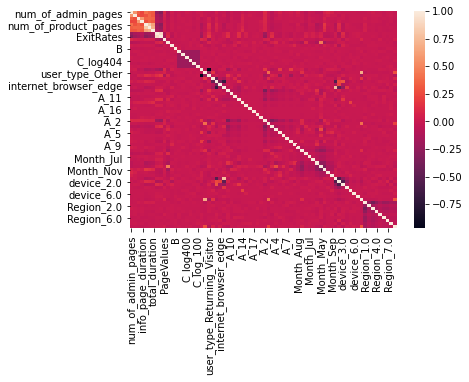

In [48]:
print("correlation matrix")
corr = X_train.corr()
sns.heatmap(corr)

In [49]:
corr_mat = X_train.corr(method='pearson').abs()
corr_mat = corr_mat[(corr_mat>0.55) & (corr_mat!=1)]
  
# Convert correlation matrix to 1-D Series and sort
sorted_mat = corr_mat.unstack().sort_values(ascending=False).dropna()
sorted_mat[::2]


user_type_New_Visitor    user_type_Returning_Visitor    0.970351
ExitRates                BounceRates                    0.911311
num_of_product_pages     product_page_duration          0.821677
device_1.0               internet_browser_safari        0.776018
product_page_duration    total_duration                 0.682883
device_8.0               user_type_Other                0.677282
internet_browser_chrome  internet_browser_safari        0.675893
total_duration           num_of_product_pages           0.629481
info_page_duration       num_of_info_pages              0.588900
admin_page_duration      num_of_admin_pages             0.564521
device_3.0               device_2.0                     0.556983
device_1.0               device_2.0                     0.555734
dtype: float64

We focused on medium and high correlation (corr>0.55).
- As we saw earlier, Total duration is highly correlated with 'product page duration' and 'num of the product pages'. For that reason, we chose to drop the column 'total duration' and also because it has a lot of missing values.
- Each 'type of page' is highly correlated with his 'number of pages' and 'duration'. We will drop one of them. We randomly decided to delete the 'number of pages' column.
- ExitRates and BonuceRates have a are highly correlated. We will combine these columns by making an averaging their values.
- Any correlations between features having  the same origin column due to the creation of dummy variables (such as user type) are meaningless.
- For some correlation it's hard to conclude. For example, 'device_1' and 'internet_browser_safari' are highly correlated but, not all types of devices and specific types of browsers correlate. In these cases we decided not to change the columns.




In [50]:
numeric_updated = numeric.copy()
col_to_combine = ["ExitRates", "BounceRates"]
X_train["avg_rates"] = X_train[col_to_combine].mean(axis = 1)
numeric_updated.append("avg_rates")


In [51]:
col_to_drop = ["num_of_product_pages", "num_of_info_pages", "num_of_admin_pages", "total_duration", "ExitRates", "BounceRates"]
X_train = remove_column(X_train, col_to_drop)


In [52]:
for c in col_to_drop:
    numeric_updated.remove(c)

In [53]:
numeric_updated

['admin_page_duration',
 'info_page_duration',
 'product_page_duration',
 'PageValues',
 'closeness_to_holiday',
 'B',
 'avg_rates']

In [54]:
X_train

,admin_page_duration,info_page_duration,product_page_duration,PageValues,closeness_to_holiday,Weekend,B,C_log200,C_log202,C_log400,...,Region_1.0,Region_2.0,Region_3.0,Region_4.0,Region_5.0,Region_6.0,Region_7.0,Region_8.0,Region_9.0,avg_rates
0,18.00,0.0,474.500000,0.000000,0.0,1,97.956342,0,0,0,...,0,0,1,0,0,0,0,0,0,0.001613
1,54.00,0.0,220.966667,0.000000,0.0,0,111.762295,1,0,0,...,0,0,0,1,0,0,0,0,0,0.025000
2,0.00,11.0,1299.196667,0.000000,0.0,1,101.429366,0,0,0,...,0,0,1,0,0,0,0,0,0,0.013091
3,8.00,0.0,346.386667,0.000000,0.0,0,99.304262,0,0,0,...,0,0,1,0,0,0,0,0,0,0.014706
4,0.00,0.0,166.120000,0.000000,0.0,0,107.093749,0,0,1,...,1,0,0,0,0,0,0,0,0,0.011111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8237,519.00,0.0,2577.960349,0.000000,0.0,0,102.585479,1,0,0,...,0,0,0,0,0,0,1,0,0,0.025071
8238,9.00,0.0,558.193333,0.000000,0.0,0,86.700449,0,1,0,...,0,0,1,0,0,0,0,0,0,0.005556
8239,61.08,0.0,1324.850000,0.000000,0.0,0,78.520357,0,1,0,...,1,0,0,0,0,0,0,0,0,0.008140
8240,0.00,0.0,111.666667,0.000000,0.0,0,100.097249,1,0,0,...,1,0,0,0,0,0,0,0,0,0.012500


### Normalization

Numerics before normalization:

In [55]:
X_train[numeric_updated]

,admin_page_duration,info_page_duration,product_page_duration,PageValues,closeness_to_holiday,B,avg_rates
0,18.00,0.0,474.500000,0.000000,0.0,97.956342,0.001613
1,54.00,0.0,220.966667,0.000000,0.0,111.762295,0.025000
2,0.00,11.0,1299.196667,0.000000,0.0,101.429366,0.013091
3,8.00,0.0,346.386667,0.000000,0.0,99.304262,0.014706
4,0.00,0.0,166.120000,0.000000,0.0,107.093749,0.011111
...,...,...,...,...,...,...,...
8237,519.00,0.0,2577.960349,0.000000,0.0,102.585479,0.025071
8238,9.00,0.0,558.193333,0.000000,0.0,86.700449,0.005556
8239,61.08,0.0,1324.850000,0.000000,0.0,78.520357,0.008140
8240,0.00,0.0,111.666667,0.000000,0.0,100.097249,0.012500


Many models perform better when features are on a relatively similar scale and/or close to normally distributed.

Scaling the numeric features to be in equally scaled.<br>
μ = 0 and σ^2 = 1.

In [56]:
scaler = StandardScaler()
normalized_numeric = pd.DataFrame(data=scaler.fit_transform(X_train[numeric_updated]), columns=numeric_updated)
X_train[numeric_updated] = normalized_numeric
X_train[numeric_updated]

,admin_page_duration,info_page_duration,product_page_duration,PageValues,closeness_to_holiday,B,avg_rates
0,-0.340499,-0.237038,-0.358629,-0.309935,-0.304946,-0.180383,-0.654131
1,-0.138038,-0.237038,-0.487941,-0.309935,-0.304946,1.231641,-0.159612
2,-0.441729,-0.160341,0.061999,-0.309935,-0.304946,0.174826,-0.411429
3,-0.396738,-0.237038,-0.423972,-0.309935,-0.304946,-0.042522,-0.377281
4,-0.441729,-0.237038,-0.515915,-0.309935,-0.304946,0.754159,-0.453292
...,...,...,...,...,...,...,...
8237,2.477075,-0.237038,0.714220,-0.309935,-0.304946,0.293069,-0.158103
8238,-0.391114,-0.237038,-0.315942,-0.309935,-0.304946,-1.331596,-0.570764
8239,-0.098221,-0.237038,0.075084,-0.309935,-0.304946,-2.168227,-0.516126
8240,-0.441729,-0.237038,-0.543689,-0.309935,-0.304946,0.038581,-0.423924


### PCA

number of components which preserve at least 99% of the variance: 43


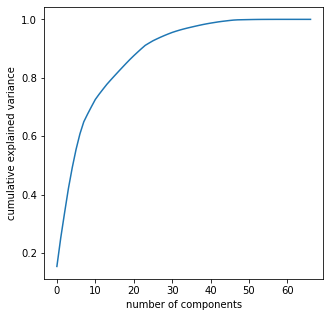

In [57]:
def plot_pca(X, p):
    pca = PCA().fit(X)
    var = np.cumsum(pca.explained_variance_ratio_)
    i = np.argwhere(var >= p)[0][0]
    principal_components = pca.components_
    components = principal_components[:i+1, :]
    print(f'number of components which preserve at least 99% of the variance: {len(components)}')
    plt.figsize=(5, 5)
    plt.plot(var)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')

plt.figure(figsize=(5,5))
plot_pca(X_train,0.99)


In [58]:
def get_principal_components(X, p, pca = None):
    """
    Returns array of principal components explaining (100*p)% of the variance
    X: 2d numpy array of data we want to apply PCA on. 
    p: float in the range (0,1]. The proportion of variance explained by components
    """
    if pca == None:
        pca = PCA(n_components=p, svd_solver ="auto").fit(X)
        newdata_transformed = pd.DataFrame(pca.transform(X))
        return pca, newdata_transformed
    else:
        newdata_transformed = pd.DataFrame(pca.transform(X))
        return pca, newdata_transformed

PCA_data = get_principal_components(X_train, 0.99)
PCA_details = PCA_data[0]
X_train_trans = PCA_data[1]
print("original shape:   ", X_train.shape)
print("transformed shape:", X_train_trans.shape)



original shape:    (8242, 67)
transformed shape: (8242, 43)


In [59]:
X_train_trans

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,-0.238920,-0.595781,-0.032638,-0.408563,-0.671611,-0.186373,-0.703259,1.324102,0.013335,-0.410175,...,-0.055253,-0.069702,-0.013677,-0.007212,-0.060685,-0.082871,-0.066721,-0.020877,-0.010249,-0.000295
1,-0.562544,-0.225641,-1.043057,0.603136,-0.257021,0.175986,-0.715243,1.126904,-0.192741,-0.721601,...,0.263645,0.570039,0.086398,0.203397,0.173261,-0.286540,-0.531315,-0.046241,-0.263534,0.104543
2,-0.107535,-0.394174,-0.333081,-0.185358,-0.470181,-0.231851,-0.350492,1.495024,0.056317,-0.373869,...,-0.390212,0.454288,0.083666,-0.595673,-0.260606,-0.098026,-0.006301,-0.129078,0.019786,-0.127530
3,-0.463999,-0.282021,-0.134578,-0.248840,-0.437362,-0.222733,-0.144936,-0.255280,1.024336,-0.824974,...,-0.282602,-0.225349,-0.013188,0.058704,0.691140,-0.318872,0.015925,-0.042283,-0.037998,-0.130473
4,-0.486400,-0.431412,-0.723277,0.284678,-0.496345,-0.402240,0.149998,-0.593656,-0.278464,0.114705,...,-0.284445,-0.118652,-0.003762,0.117156,0.793832,-0.317436,0.097883,-0.009676,0.023803,-0.142710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8237,1.591639,0.390756,-0.601709,-0.107389,-0.417025,1.854843,0.053804,-0.898261,-0.451627,-0.588643,...,-0.263445,-0.104959,-0.114400,0.092338,0.821564,-0.316081,0.119850,-0.056952,0.035028,-0.137022
8238,-0.240406,-0.328114,0.874245,-1.050339,-0.612351,-0.388596,0.236935,-0.620923,-0.263237,-0.894111,...,-0.252913,0.185058,-0.145867,0.719718,-0.367049,0.085986,0.090632,-0.013366,0.003163,-0.136033
8239,0.166033,-0.149593,1.526296,-1.533356,-0.645950,-0.193311,0.392029,-0.484440,-0.214348,0.244244,...,0.689042,-0.315401,0.031140,-0.147248,-0.118582,0.042745,-0.096167,-0.027960,-0.097947,-0.047695
8240,-0.494610,-0.419772,-0.223808,-0.218020,-0.497142,-0.398896,0.124547,-0.664348,-0.323057,0.073670,...,-0.013982,-0.081975,-0.022192,-0.005094,-0.024555,-0.015790,-0.035737,-0.029951,-0.042878,0.018628


We gathered together all the processing we did into one function

In [60]:
def pre_process_train(x_train, y_train, pca = None):
    # handle columns with 'minutes' suffix
    cols_to_change = ["info_page_duration", "product_page_duration"] 
    for col in cols_to_change:
        x_train[col] = change_coloumn(x_train, col, " ", 0)
        x_train[col] = x_train[col].astype(float)
    
    #types of columns
    all_cols = x_train.columns
    numeric = list(x_train.select_dtypes(include=[np.number]).columns) # numeric columns
    non_numeric = list(set(all_cols) - set(numeric)) # non numeric columns
    
    #changing columns device and region to be categorial variable
    for c in ["device", "Region"]: 
        numeric.remove(c)
        non_numeric.append(c)
        x_train[c] = x_train[c].astype(object)

    # remove rows which have less than 17 features
    feature_count = x_train.shape[1] - x_train.isnull().sum(axis=1)
    less_17_features = feature_count.values<17
    to_remove = np.where(less_17_features)
    x_train, y_train = remove_row(x_train, y_train, to_remove[0])

    #remove sample which are oulier according to feature B
    Q1 = x_train["B"].quantile(0.25)
    Q3 = x_train["B"].quantile(0.75)
    IQR = Q3 - Q1
    B_outlier = (x_train["B"] < (Q1 - 1.5 * IQR)) |(x_train["B"] > (Q3 + 1.5 * IQR))
    to_remove = np.where(B_outlier)
    x_train, y_train = remove_row(x_train, y_train, to_remove[0])

    #remove column d
    x_train = remove_column(x_train, "D")
    numeric.remove("D") #update the numric list that we removed feature D.
    

    #changing column internet browser, save only the name of the browser type (remove the part after_)
    x_train["internet_browser"] = change_coloumn(x_train, "internet_browser", "_", 0)

    #changing column A: grouped by main suspect version and remove the prefix c
    x_train["A"] = change_coloumn(x_train, "A", "_", 1)

    #Categorical Features: filling missing values by most frequent
    cat_most_freq = {}  #dictionary that saves most frequent values of the train categorical features
    for col in non_numeric:
            x_train = cat_filling_null(col, x_train, cat_most_freq)


    #Numerical Features: filling missing values by mean for feature B and median for the other numerical columns.
    num_mean = {} #dictionary that saves most avg values of the train numerical features (except B)
    num_median = {} #dictionary that saves median value of the train numerical column B
    for col in numeric:
        if col == "B":
            x_train = num_filling_null_mean(col, x_train, num_mean)
        else:
            x_train = num_filling_null_median(col, x_train, num_median)

    #Change column "Weekend" from boolean string(True/False) to 1/0
    x_train = change_boolean(x_train, "Weekend")
    
    #Create Dummy Variables for categorical columns
    non_numeric_cat = non_numeric.copy() #list of columnns that will create for them dummy varaibles (except weekend which is boolean)
    non_numeric_cat.remove("Weekend")
    x_train = change_to_dummies(x_train, non_numeric_cat)
    
    #Union of 2 correlated columns: "ExitRates", "BounceRates" by doing average of their values
    numeric_updated = numeric.copy()
    col_to_combine = ["ExitRates", "BounceRates"]
    x_train["avg_rates"] = x_train[col_to_combine].mean(axis = 1)
    numeric_updated.append("avg_rates")

    #drop correlated columns
    col_to_drop = ["num_of_product_pages", "num_of_info_pages", "num_of_admin_pages", "total_duration", "ExitRates", "BounceRates"]
    x_train = remove_column(x_train, col_to_drop)
    for c in col_to_drop:
        numeric_updated.remove(c)

    #normalization
    scaler = StandardScaler()
    normalized_numeric = pd.DataFrame(data=scaler.fit_transform(x_train[numeric_updated]), columns=numeric_updated)
    x_train[numeric_updated] = normalized_numeric
    
    #pca
    if pca != None:
        PCA_data = get_principal_components(x_train, 0.99)
        PCA_details = PCA_data[0]
        x_train_trans = PCA_data[1]
        return y_train, x_train, cat_most_freq, num_mean, num_median, numeric, numeric_updated, non_numeric,non_numeric_cat, col_to_combine, col_to_drop, scaler, PCA_details, x_train_trans
        
         
    return y_train, x_train, cat_most_freq, num_mean, num_median, numeric, numeric_updated, non_numeric,non_numeric_cat, col_to_combine, col_to_drop, scaler

In [61]:
# We ran the function pre_process_train on a copy of the train to do everything in a continuous and orderly manner
train_after_proc_and_pca = pre_process_train(x_train_copy, y_train_copy, 1)
x_train_after_proc_and_pca = train_after_proc_and_pca[-1]
y_train_after_proc_and_pca = train_after_proc_and_pca[0]

In [62]:
#to validate that we did not miss a function in pre processing train function
x_train_after_proc_and_pca.equals(X_train_trans)


True

In [63]:
def pre_process_test(x_test, x_train, cat_most_freq, num_mean, num_median, numeric, numeric_updated, non_numeric, non_numeric_cat, col_to_combine, col_to_drop, scaler, PCA_details = None):
    # handle columns with 'minutes' suffix 
    cols_to_change = ["info_page_duration", "product_page_duration"]
    for col in cols_to_change:
        x_test[col] = change_coloumn(x_test, col, " ", 0)
        x_test[col] = x_test[col].astype(float)

    #remove column d
    x_test = remove_column(x_test, "D")

    #changing column internet browser (remove the part after_)
    x_test["internet_browser"] = change_coloumn(x_test, "internet_browser", "_", 0)

    #changing column A 
    x_test["A"] = change_coloumn(x_test, "A", "_", 1)

    #Categorical Features: filling missing values by most frequent
    for col in non_numeric:
        x_test = cat_filling_null(col, x_test, cat_most_freq, 1)


    #Numerical Features: filling missing values by mean for feature B and median for the other numerical columns.
    for col in numeric:
        if col == "B":
            x_test = num_filling_null_mean(col, x_test, num_mean, 1)
        else:
            x_test = num_filling_null_median(col, x_test, num_median, 1)
    
    #Change column "weekend" from boolean string(True/False) to 1/0
    x_test = change_boolean(x_test, "Weekend")
    
    #Create Dummy Variables for categorical columns
    x_test = change_to_dummies(x_test, non_numeric_cat)
    
    #drop correlated columns
    x_test["avg_rates"] = x_test[col_to_combine].mean(axis = 1)
    x_test = remove_column(x_test, col_to_drop)


    # Get missing columns in the test and set them with default value equal to 0
    missing_cols = set(x_train.columns) - set(x_test.columns)
    for c in missing_cols:
        x_test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    x_test = x_test[x_train.columns]

    #normalization
    normalized_numeric = pd.DataFrame(data=scaler.transform(x_test[numeric_updated]), columns=numeric_updated)
    x_test[numeric_updated] = normalized_numeric
    

    #pca
    if PCA_details != None:
        PCA_data = get_principal_components(x_test, 0.99, PCA_details)
        x_test = PCA_data[1]

    
    return x_test

In [64]:
list(train_after_proc_and_pca)
test_after_proc_and_pca= pre_process_test(x_test_copy, *train_after_proc_and_pca[1:-1])
x_test_after_proc_and_pca = test_after_proc_and_pca
y_test_after_proc_and_pca = y_test_copy

# Parts 3 and 4 - Model Running And Model Evaluation

##### Utility functions:

In [65]:
def grid_search(estimator, param_grid, x, y):
    grid = GridSearchCV(estimator=estimator(), param_grid=param_grid, scoring='roc_auc', cv=10)
    grid.fit(x,y)
    return grid

In [66]:
def plot_roc(model, name, param, n_splits, x_train, y_train, x_test, y_test):
    cv = StratifiedKFold(n_splits)
    if model==SVC:
        classifier = model(**param,probability=True)
    else:
        classifier = model(**param)
    X = np.array(x_train)
    y = np.array(y_train)
    aucs = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(7, 7))
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X[test],
            y[test],
            name=" Validation AUC of Train fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean Validation of Train folds (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    full_model = classifier.fit(x_train, y_train)
    train_roc = RocCurveDisplay.from_estimator(
        full_model,
        np.array(x_train),
        np.array(y_train),
        name="Train AUC",
        alpha=0.4,
        color = "black",
        lw=1,
        ax=ax,
        )
    test_roc = RocCurveDisplay.from_estimator(
            full_model,
            np.array(x_test),
            np.array(y_test),
            name="Test AUC",
            alpha=0.4,
            color = "blue",
            lw=1,
            ax=ax,
        )


    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=f"ROC for {name}",
    )
    ax.legend(loc="lower right")
  
    plt.show()

    
    train_auc = roc_auc_score(y_train, full_model.predict_proba(x_train)[:,1])
    test_auc = roc_auc_score(y_test, full_model.predict_proba(x_test)[:,1])

    scores = np.array([train_auc, test_auc, train_auc - test_auc])
    model_scores_series = pd.Series(scores, name= name)
    return model_scores_series

 We tried out the following models: Logistic Regression, Gaussian Naive Bayes, SVM and Adaptive Boosting after pre processing (with PCA):

#### Logistic Regression

In [67]:
param_log ={"penalty": ["l1", "l2"], "C":[0.001, 0.01, 0.1, 1, 10],"solver": ["liblinear"] , "max_iter":[50, 100, 200]}
log_reg = grid_search(LogisticRegression, param_log, x_train_after_proc_and_pca, y_train_after_proc_and_pca)
log_param = log_reg.best_params_

In [68]:
print(f'best hyperparameters for Logistic Regression:{log_param}')

best hyperparameters for Logistic Regression:{'C': 0.01, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}


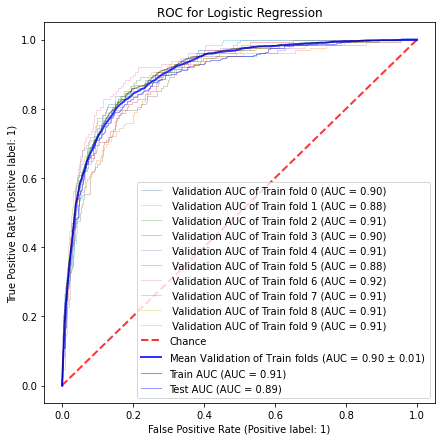

In [69]:
log_reg_scores_series = plot_roc(LogisticRegression, "Logistic Regression", log_param, 10,x_train_after_proc_and_pca, y_train_after_proc_and_pca, x_test_after_proc_and_pca, y_test_after_proc_and_pca)


#### Gaussian Naive Bayes

In [70]:
clf = GaussianNB(priors = None)
clf.fit(x_train_after_proc_and_pca, y_train_after_proc_and_pca)

GaussianNB()

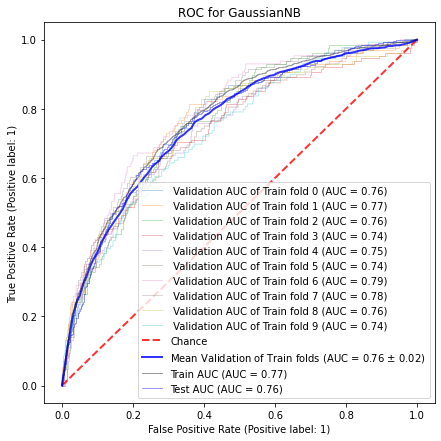

In [71]:
no_param = {}
GaussianNB_scores_series = plot_roc(GaussianNB, "GaussianNB", no_param, 10, x_train_after_proc_and_pca, y_train_after_proc_and_pca, x_test_after_proc_and_pca, y_test_after_proc_and_pca)

#### SVM

In [72]:
param_svm = {'C': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10], 'kernel': ['rbf']}

svm = grid_search(SVC, param_svm, x_train_after_proc_and_pca, y_train_after_proc_and_pca)
svm_param = svm.best_params_

In [73]:
print(f'best hyperparameters for SVM:{svm_param}')

best hyperparameters for SVM:{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}


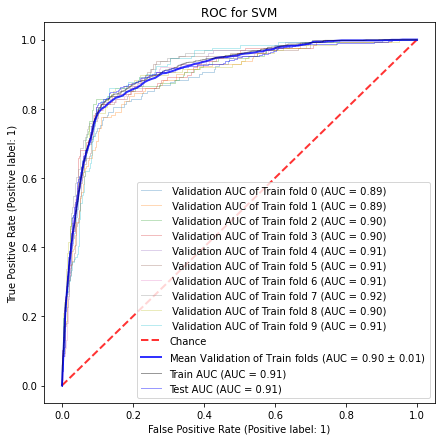

In [74]:

svm_scores_series = plot_roc(SVC, "SVM", svm_param, 10, x_train_after_proc_and_pca, y_train_after_proc_and_pca, x_test_after_proc_and_pca, y_test_after_proc_and_pca)

#### Adaptive Boosting

In [75]:
param_adaboost = {
    'random_state':[0],
    'n_estimators':[50, 200, 500]
}

adaboost = grid_search(AdaBoostClassifier, param_adaboost, x_train_after_proc_and_pca, y_train_after_proc_and_pca)
adaboost_param = adaboost.best_params_

In [76]:
print(f'best hyperparameters for Adaptive Boosting:{adaboost_param}')

best hyperparameters for Adaptive Boosting:{'n_estimators': 50, 'random_state': 0}


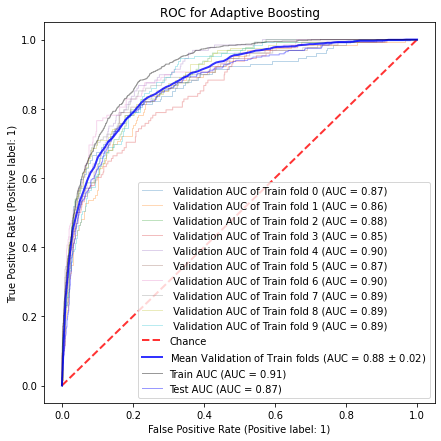

In [77]:
adaboost_scores_series = plot_roc(AdaBoostClassifier, "Adaptive Boosting", adaboost_param, 10, x_train_after_proc_and_pca, y_train_after_proc_and_pca, x_test_after_proc_and_pca, y_test_after_proc_and_pca)

We put the scores of all the models we ran on the data:

In [78]:
score_type = pd.DataFrame({'Score Type': ['Train AUC', 'Test_AUC', 'Difference']})
scores_df = pd.concat([score_type, log_reg_scores_series, GaussianNB_scores_series, svm_scores_series, adaboost_scores_series], axis=1)
scores_df.set_index('Score Type')


,Logistic Regression,GaussianNB,SVM,Adaptive Boosting
Score Type,,,,
Train AUC,0.906141,0.773759,0.908733,0.913609
Test_AUC,0.893045,0.763117,0.906324,0.867357
Difference,0.013096,0.010642,0.002409,0.046252


#### SVM Confusiom Matrix

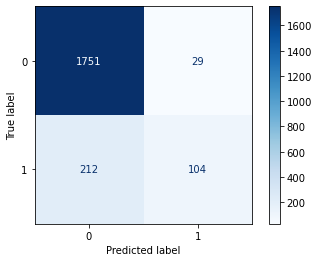

In [79]:
chosen_model = SVC(**svm_param)
chosen_model.fit(x_train_after_proc_and_pca, y_train_after_proc_and_pca)
plt.figsize=(5, 5)
plot_confusion_matrix(chosen_model, x_test_after_proc_and_pca, y_test_after_proc_and_pca, cmap='Blues')


__<ins>Explanation:</ins>__<br>

<ins>Cells which represent the model's correct predictions:</ins><br>

- True Positive - 104 samples where the model predicted a purchase (1) and was right.

- True Negative - 1751 samples where the model predicted no purchase (0) and was right.

<ins>Cells which represent the model's errors:</ins><br>

- False Positive - 29 samples where the model predicted a purchase (1) and was wrong.

- False Negative - 212 samples where the model predicted no purchase (0) and was wrong.

Evaluation of the model's performance:</ins><br>

- Accuracy (Percentage of samples that were correctly labeled) $\ \frac{TP+TN}{TP+FP+FN+TN}$ = $\ \frac{104+1751}{104+1751+29+212}$ ~ 89% <br>

- Precision (Confidence in true positives): $\ \frac{TP}{TP+FP}$ = $\ \frac{104}{104+29}$ ~ 78% <br>

- Sensitivity (Confidence in not missing positives) $\ \frac{TP}{TP+FN}$ = $\ \frac{104}{104+212}$ ~ 33%

- Specificity (Percentage of correct predictions out of all none purchases which are truly 0 labeled): $\ \frac{TN}{TN+FP}$ = $\ \frac{1751}{1751+29}$ ~ 98% <br>

# Part 5 - Execution Of Predictions

Pipeline

In [80]:
#open train file
data = pd.read_csv('train.csv')
data = pd.DataFrame(data.iloc[: , 1:])
name_col = data.columns[:-1]
x_full_train = pd.DataFrame(data.iloc[:,:-1].values, columns = name_col)
y_full_train = pd.DataFrame(data.iloc[:,-1])
types_col = dict(data.dtypes[:-1])
x_full_train = x_full_train.astype(types_col)
#pre processing training data
full_train_after_proc_and_pca = pre_process_train(x_full_train, y_full_train, 1)
x_full_train = full_train_after_proc_and_pca[-1]
y_full_train = full_train_after_proc_and_pca[0]
list(full_train_after_proc_and_pca)
#open test file
data_test = pd.read_csv('test.csv')
name_col = data_test.columns[1:]
index_test = pd.DataFrame(data_test.iloc[: , 1:])
final_test = pd.DataFrame(data_test.iloc[: , 1:])
x_final_test = pd.DataFrame(final_test.values, columns = name_col)
type_col = dict(data_test.dtypes[1:])
x_final_test = x_final_test.astype(type_col)
#pre processing test data
final_test_after_proc_and_pca= pre_process_test(x_final_test, *full_train_after_proc_and_pca[1:-1])
#running SVM with the best hyper parameters
classifier = SVC(**svm_param,probability=True)
classifier.fit(x_full_train, y_full_train)
# find probability to be 1 (purchase) for the test set
prob_test = pd.DataFrame(classifier.predict_proba(final_test_after_proc_and_pca))
prob_test_1 = pd.DataFrame(prob_test[1].values, columns = ["predict_prob"])
#export test prediction to csv file
prob_test_1.to_csv("Submission_group_8.csv", index = True, index_label = "index")